In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breastcancerwisconsin/breast-cancer-wisconsin.data


In [58]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import *
from sklearn.metrics import *


In [103]:
def plot_all(X_test, y_test, all_clfs, clf_names, file_name):
    plt.figure(figsize=(16,8))
    plt.suptitle("Dataset: %s"%file_name, size=16)
    plt.subplot(121)
    roc_scores = plot_roc_curve(X_test, y_test, all_clfs, clf_names)
    plt.subplot(122)
    pr_scores = plot_pr_curve(X_test, y_test, all_clfs, clf_names)
    plt.show()
    return roc_scores, pr_scores
#plot tools
def plot_roc_curve(X_test, y_test, all_clfs, clf_names):
    roc_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]

    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes 
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, preds)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            roc_scores[clf_name] = roc_auc
            plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')         
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:,i],y_score[:,i])
                roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(),y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            roc_scores[clf_name] = roc_auc["micro"]
            plt.plot(fpr["micro"], tpr["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,roc_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')        
    return roc_scores
def plot_pr_curve(X_test, y_test, all_clfs, clf_names):
    pr_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Precision-Recall Curve')
    plt.plot([0, 1], [1, 0],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]
    
    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, preds)
            pr_auc = sklearn.metrics.auc(recall, precision)
            pr_scores[clf_name] = pr_auc
            plt.plot(recall, precision, 'b', label = '%s (AUC = %0.3f)' % (clf_name,pr_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            precision = dict()
            recall = dict()
            pr_auc = dict()
            for i in range(n_classes):
                precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y_test[:,i],y_score[:,i])
                pr_auc[i] = sklearn.metrics.auc(recall[i], precision[i])
            # Compute micro-average ROC curve and ROC area
            precision["micro"], recall["micro"], _ = sklearn.metrics.precision_recall_curve(y_test.ravel(),y_score.ravel())
            pr_auc["micro"] = sklearn.metrics.auc(recall["micro"], precision["micro"])  
            pr_scores[clf_name] = pr_auc["micro"]
            plt.plot(recall["micro"], precision["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,pr_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
    return pr_scores

def confusion_classification_report(X_test,y_test, all_clfs, clf_names):
    for clf, clf_name in zip(all_clfs, clf_names):
        y_pred=clf.predict(X_test)
        plot_confusion_matrix(clf,X_test,y_test)
        strr="Classification Report of "+clf_name
        print(strr)
        c_report=classification_report(y_test, y_pred)
        print(c_report)
        
    

In [60]:
import sklearn
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
def replace_question_marks(df):
    try:
        df = df.replace({'?' : np.nan})
        print("Replaced all '?' to np.nan")
    except:
        print('No question marks found')
    return df

#check whether dataset is balanced
def check_class_distribution(df):
    print('Class distributions:')
    print(df.iloc[:,-1].value_counts())
    
#PCA dimension reducetion
def dimension_reduction(x_train, x_test, upper_bound=500, n_components=50,):
    if x_train.shape[1] >= upper_bound:
        pca = PCA(n_components=n_components, random_state=33)
        pca.fit(x_train)
        x_train= pd.DataFrame(pca.transform(x_train))
        x_test = pd.DataFrame(pca.transform(x_test))
        print("Reducing dimension form %s to %s"%(x_train.shape[1],n_components))
    return x_train, x_test

#encoder for X and y string values
def encode_labels(x_train, x_test, index=None):
    label_encoder = sklearn.preprocessing.LabelEncoder()
    df = pd.concat([x_train,x_test],axis=0)
    
    #encoding y labels
    if index == -1:
        print('Encoding y label values')
        not_null_df = df[df.notnull()]
        label_encoder.fit(not_null_df)
        x_train = label_encoder.transform(x_train)
        x_test = label_encoder.transform(x_test)
    
    #encoding x features
    else:
        print('Encoding X features')
        for i,t in enumerate(df.dtypes):
            if t == 'object':
                s_df = df.iloc[:,i]
                not_null_df = s_df.loc[s_df.notnull()]
                label_encoder.fit(not_null_df)
                try:
                    x_train.iloc[:,i] = x_train.iloc[:,i].astype('float')
                except:
                    x_train.iloc[:,i] = x_train.iloc[:,i].apply(lambda x: label_encoder.transform([x])[0] if x not in [np.nan] else x)
                try:
                    x_test.iloc[:,i] = x_test.iloc[:,i].astype('float')
                except:
                    x_test.iloc[:,i] = x_test.iloc[:,i].apply(lambda x: label_encoder.transform([x])[0] if x not in [np.nan] else x) #np.nan
    return x_train, x_test

#put class colunmn at end of dataframe
def reorder_columns(dataFrame):
    cols = dataFrame.columns.tolist()
    cols = cols[1:] + cols[:1]
    return dataFrame[cols]

#impute np.nan using given strategy
def impute_value(x_train, x_test, strategy):
    if strategy == None:
        return x_train.dropna(), x_test.dropna()
    else:
        imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
        train_type_dic = dict()#keep original train data type before impute
        for i,t in enumerate(x_train.dtypes):
            if t != 'object':
                train_type_dic[i] = t
        test_type_dic = dict()#keep original test data type before impute
        for i,t in enumerate(x_test.dtypes):
            if t != 'object':
                test_type_dic[i] = t
        x_train = pd.DataFrame(imp.fit_transform(x_train))
        x_test = pd.DataFrame(imp.transform(x_test))
#         for key in train_type_dic:
#             x_train.iloc[:,key] = x_train.iloc[:,key].astype(train_type_dic[key])
#         for key in test_type_dic:
#             x_test.iloc[:,key] = x_test.iloc[:,key].astype(test_type_dic[key])
    return x_train, x_test
    
# default normalizer -> MinMaxScaelr
def normalize_data(X_train, X_test, scaler = preprocessing.MinMaxScaler()):
#     scaler = preprocessing.StandardScaler().fit(X_train)
    print('Normalized data by scaler: %s'%type(scaler))
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [85]:
# classifiers
def train_KNN(X_train, y_train):
    print('Training KNN ...')
    knn = KNeighborsClassifier()
#     scoring = ['roc_auc']
    param_distributions = {
        'n_neighbors' : scipy.stats.randint(1,20)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        knn,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    return randcv.best_estimator_

def train_SVM(X_train, y_train):
    print('Training SVM ...')
    svm = SVC(kernel='rbf', probability=True, cache_size=3000, random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 100.),
        'gamma' : scipy.stats.reciprocal(0.01, 10.),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        svm,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_RandomForest(X_train, y_train):
    print('Training RandomForest ...')
    forest = RandomForestClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,100),
        'n_estimators' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_AdaBoost(X_train, y_train):
    print('Training AdaBoost ...')
    boost = AdaBoostClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,70)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_    

def train_LogisticRegression(X_train, y_train):
    print('Training LogisticRegression ...')
    lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 1000.),
        'max_iter' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        lr,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_GaussianNaiveBayes(X_train, y_train):
    print('Training GaussianNaiveBayes ...')
    gaussian = GaussianNB()
#     scoring = ['roc_auc']
    param_distributions = {
        'var_smoothing' : scipy.stats.uniform(1e-10, 1e-9),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        gaussian,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

In [86]:
def run_all_clfs(X_train, y_train, X_test, y_test):
    all_clfs = []
    clf_names = []

    clf1 = train_KNN(X_train, y_train)
    all_clfs.append(clf1)
    clf_names.append('KNN')

    clf2 = train_SVM(X_train, y_train)
    all_clfs.append(clf2)
    clf_names.append('SVM')

    clf3 = train_DecisionTree(X_train, y_train)
    all_clfs.append(clf3)
    clf_names.append('Decision Tree')

    clf4 = train_RandomForest(X_train, y_train)
    all_clfs.append(clf4)
    clf_names.append('Random Forest')

    clf5 = train_AdaBoost(X_train, y_train)
    all_clfs.append(clf5)
    clf_names.append('AdaBoost')

    clf6 = train_LogisticRegression(X_train, y_train)
    all_clfs.append(clf6)
    clf_names.append('Logistic regression')

    clf7 = train_GaussianNaiveBayes(X_train, y_train)
    all_clfs.append(clf7)
    clf_names.append('Gaussian Naive Bayes')
    
    return all_clfs, clf_names

In [98]:
def make_classification(file, df, df_test):
    print("Dataset : %s" % file)
    #     df.info()
    check_class_distribution(df)
    df = replace_question_marks(df)
    df_test = replace_question_marks(df_test)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    assert len(y.shape) == 1, "wrong shape of y"

    if type(df_test) == type(None):
        print('No default test set, dataset splitted')
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    else:
        print('Loaded given test set')
        X_train = X
        y_train = y
        X_test = df_test.iloc[:,:-1]
        y_test = df_test.iloc[:,-1]      

    X_train, X_test = encode_labels(X_train,X_test)
    X_train, X_test = dimension_reduction(X_train,X_test)

    #     X_train, X_test = impute_value(X_train, X_test, strategy = 'most_frequent')
    X_train, X_test = impute_value(X_train, X_test,strategy = 'mean')
    X_train, X_test = normalize_data(X_train, X_test)

    y_train, y_test = encode_labels(y_train, y_test, -1)
    
    all_clfs, clf_names = run_all_clfs(X_train, y_train, X_test, y_test)
    confusion_classification_report(X_test,y_test, all_clfs, clf_names)
    roc_scores, pr_scores = plot_all(X_test, y_test, all_clfs, clf_names, file)
  
    return roc_scores, pr_scores

In [64]:
file3 = 'breast-cancer-wisconsin.data'
df3 = pd.read_csv("/kaggle/input/breastcancerwisconsin/breast-cancer-wisconsin.data",header=None, index_col=0)
#df3 = df3[df3[6]!='?'].astype('int64')
clfs_all_roc_scores = dict()
clfs_all_pr_scores = dict()

In [89]:
df3.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


Dataset : breast-cancer-wisconsin.data
Class distributions:
2    458
4    241
Name: 10, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Classification Report of KNN
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       135
           1       0.93      0.95      0.94        75

    accuracy                           0.96       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.96      0.96      0.96       210

Classification Report of SVM
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       135
           1       0.9

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.00784313725490196, 0.4470588235294118, 0.6352941176470588, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.00784313725490196, 0.4470588235294118, 0.6352941176470588, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.00784313725490196, 0.4470588235294118, 0.6352941176470588, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt str

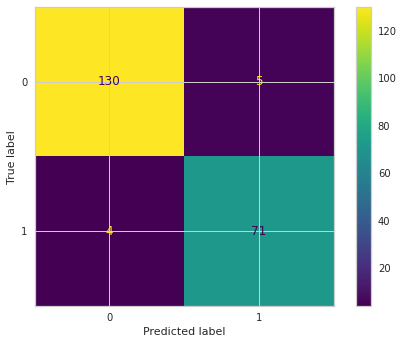

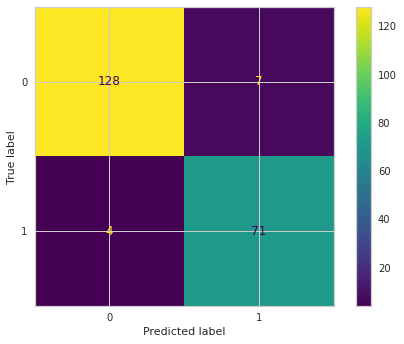

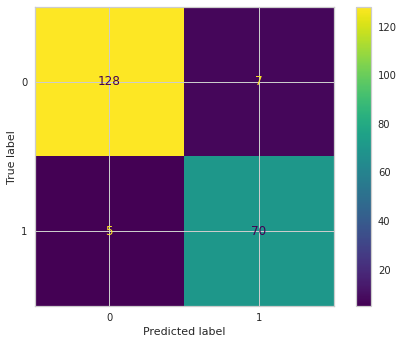

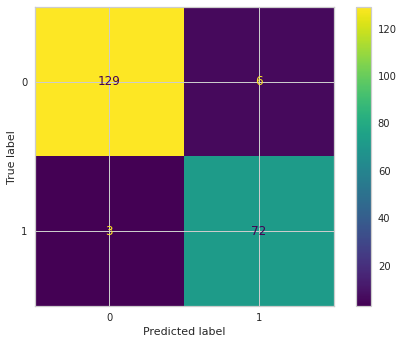

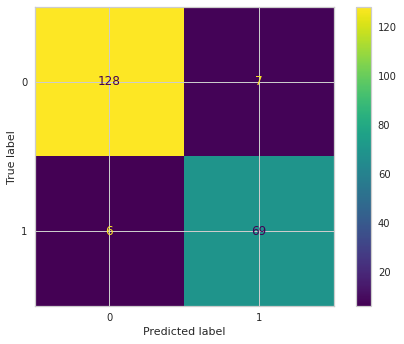

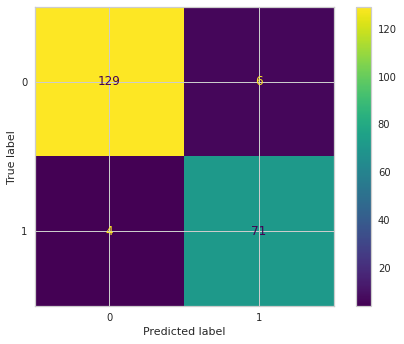

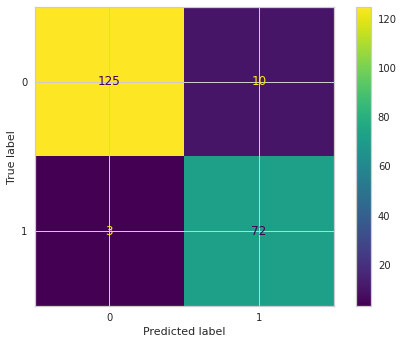

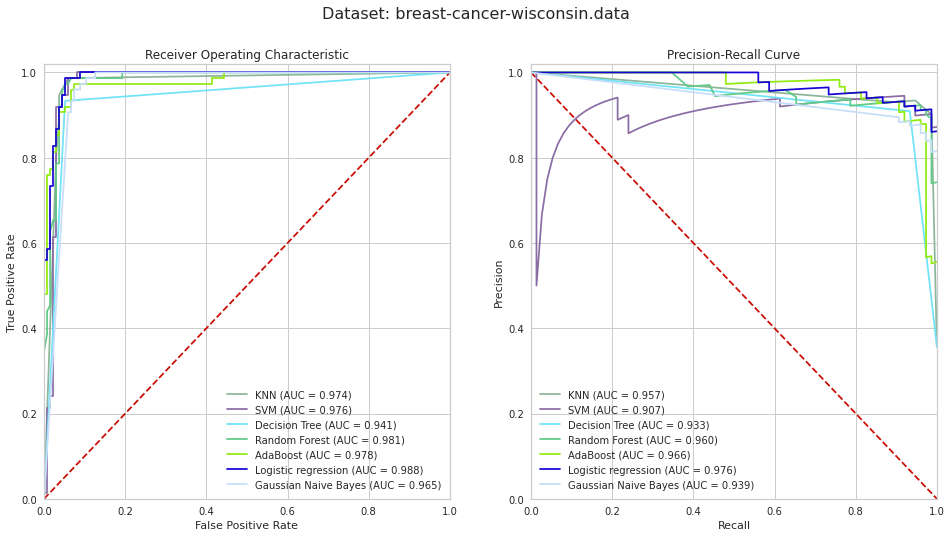

In [104]:
roc_scores, pr_scores = make_classification(file3, df3, None)